In [23]:
# helper
from graphviz import Digraph

def _trace(root):
    nodes, edges = set(), []

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.append((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    nodes, edges = _trace(root)

    for n in nodes:
        uid = str(id(n))
        label = f"{n.data}"
        if n.operation:
            label += f" | {n.operation}"
        label += f" | ∇={n.grad}"
        dot.node(uid, label=label, shape="record")

    for src, dst in edges:
        dot.edge(str(id(src)), str(id(dst)))

    return dot

In [24]:
import numpy as np
from numbers import Real

def _unbroadcast(grad, target_shape):
    while grad.ndim > len(target_shape):
        grad = grad.sum(axis=0)
    for axis, size in enumerate(target_shape):
        if size == 1:
            grad = grad.sum(axis=axis, keepdims=True)
    return grad

class Value():
    def __init__(self, data, operation="", children=()):
        if isinstance(data, (list, tuple, Real)):
            data = np.array(data, dtype=float)
        assert isinstance(data, np.ndarray), "data must be a numpy array"
        self.data = data
        self.operation = operation
        self.children = children
        self.grad = np.zeros_like(self.data, dtype=float)
        self._backward = lambda: None

    def __repr__(self):
        return str(self.data)
    
    def dot(self, other):
        other = other if isinstance(other, Value) else Value(other)
        assert self.data.ndim == 1 and other.data.ndim == 1, "Dot product is only defined for vectors"
        result = Value(np.dot(self.data, other.data), "•", (self, other))
        def _backward():
            self.grad += result.grad * other.data
            other.grad += result.grad * self.data
        result._backward = _backward
        return result

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data + other.data, "+", (self, other))
        def _backward():
            self.grad += _unbroadcast(result.grad, self.data.shape)
            other.grad += _unbroadcast(result.grad, other.data.shape)
        result._backward = _backward
        return result

    def __mul__(self, other): # multiplication is element-wise
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data * other.data, "*", (self, other))

        def _backward():
            self.grad += _unbroadcast(result.grad * other.data, self.data.shape)
            other.grad += _unbroadcast(result.grad * self.data, other.data.shape)
        result._backward = _backward
        return result
    
    def __pow__(self, other):
        assert isinstance(other, (float, int)), "power must be float or integer" # must force "other" to be primitive float or int
        result = Value(self.data ** other, "^", (self,))
        def _backward():
            self.grad += _unbroadcast(other * self.data ** (other - 1) * result.grad, self.data.shape)
        result._backward = _backward
        return result
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + -other
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def __radd__(self, other):
        return self + other
    
    def __rsub__(self, other):
        return -self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __rtruediv__(self, other):
        return Value(other) / self
    
    def sum(self, axis=None, keepdims=False):
        result = Value(np.sum(self.data, axis=axis, keepdims=keepdims), "Σ", (self,))
        def _backward():
            factor = result.grad
            if axis is not None and not keepdims:
                factor = np.expand_dims(factor, axis)
            self.grad += _unbroadcast(factor * np.ones_like(self.data), self.data.shape)
        result._backward = _backward
        return result
    
    def backward(self):
        # A topological sort is a graph traversal in which each node v is visited only after all its dependencies are visited.
        # We need this, since we must call backward() on a child strictly after it has been called on its parent
        nodes = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build_topo(child)
                nodes.append(v)
        build_topo(self)
        self.grad = np.ones(self.data.shape)
        for node in reversed(nodes):
            node._backward()

    def zero_grad(self):
        visited = set()
        def _zero(v):
            if v not in visited:
                visited.add(v)
                v.grad = np.zeros_like(v.data, dtype=float)
                for child in v.children:
                    assert isinstance(child, Value), "Child must be an instance of Value"
                    _zero(child)
        _zero(self)

    def relu(self):
        result = Value(np.maximum(0, self.data), "ReLU", (self,))
        def _backward():
            self.grad += _unbroadcast((result.data > 0) * result.grad, self.data.shape)
        result._backward = _backward
        return result
    

$$ c = a \times b \quad \text{(element-wise)} $$
$$ c_{ij} = a_{i} b_{j} $$
$$ \frac{\partial c_{ij}}{\partial a_i} = b_j \qquad \frac{\partial c_{ij}}{\partial b_j} = a_i $$
$$ L = \sum_i \sum_j c_{ij} \quad \text{Example scalar loss based on matrix} $$
$$ \frac{\partial L}{\partial a_i} = \sum_j \frac{\partial L}{\partial c_{ij}} \frac{\partial c_{ij}}{\partial a_i} = \sum_j \frac{\partial c_{ij}}{\partial a_i} = \sum_j b_j \qquad \frac{\partial L}{\partial b_j} = \sum_i \frac{\partial L}{\partial c_{ij}} \frac{\partial c_{ij}}{\partial b_j} = \sum_i \frac{\partial c_{ij}}{\partial b_j} = \sum_i a_i

In [25]:
a = Value(10)
b = Value(20)
c = Value(2)
d = a + b
e = d * c
loss = 0.2 * e

loss.backward()

$$ \frac{\mathrm{dL}}{\mathrm{dL}} = 1.0 $$
$$ \mathrm{L} = 0.2 \mathrm{e} \implies \frac{\mathrm{dL}}{\mathrm{de}} = 0.2 $$
$$ \mathrm{e} = \mathrm{d} \times \mathrm{c} \implies \frac{\mathrm{de}}{\mathrm{dd}} = \mathrm{c} \quad \frac{\mathrm{de}}{\mathrm{dc}} = \mathrm{d} $$
$$ \mathrm{d} = \mathrm{a} + \mathrm{b} \implies \frac{\mathrm{dd}}{\mathrm{da}} = 1 \quad \frac{\mathrm{dd}}{\mathrm{db}} = 1$$

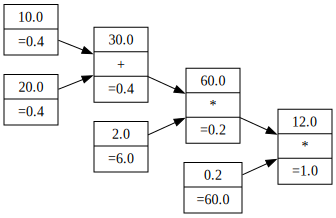

In [26]:
dot = draw_dot(loss)
dot

119.99469589159301 1.0
[ 9.43606798 11.73205081] [6.5 5. ]
[2.23606798 1.73205081] [6.5 5. ]
[5. 3.] [1.45344419 1.44337567]
[6.5 5. ] [ 9.43606798 11.73205081]
[ 7.2 10. ] [6.5 5. ]


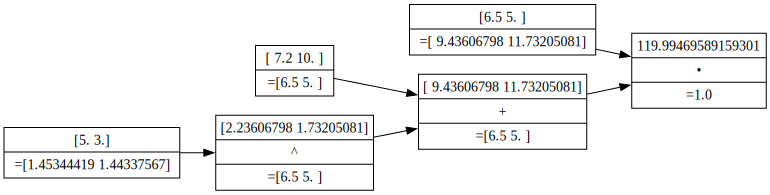

In [27]:
a = Value([5, 3])
b = Value([6.5, 5])
c = Value([7.2, 10])
d = a **0.5
e = d + c
loss = e.dot(b)

loss.backward()

print(loss.data, loss.grad)
print(e.data, e.grad)
print(d.data, d.grad)
print(a.data, a.grad)
print(b.data, b.grad)
print(c.data, c.grad)


dot = draw_dot(loss)
dot

In [28]:
import random

class Module:
    def zero_grad(self):
        for param in self.parameters():
            param.grad = np.zeros_like(param.data, dtype=float)

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, num_in, nonlin=True):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(num_in)]
        self.bias = Value(0)
        self.nonlin = nonlin
    
    def __call__(self, x):
        x = x.data if isinstance(x, Value) else np.array(x)
        act = sum((wi*xi for wi,xi in zip(self.weights, x)), self.bias)
        return act.relu() if self.nonlin else act
    
    def parameters(self):
        return self.weights + [self.bias]
    
    def __repr__(self):
        return f"Neuron(weights={self.weights}, bias={self.bias}, nonlin={self.nonlin})"

class Layer(Module):
    def __init__(self, num_in, num_out, **kwargs):
        self.neurons = [Neuron(num_in, **kwargs) for _ in range(num_out)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]
    
    def __repr__(self):
        return f"Layer(neurons={self.neurons})"
    
class MLP(Module):
    def __init__(self, num_in, num_outs):
        sz = [num_in] + num_outs
        self.layers = [Layer(sz[i], sz[i + 1], nonlin=i!=len(num_outs)-1) for i in range(len(num_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    def __repr__(self):
        return f"MLP(layers={self.layers})"

In [29]:
def MSE(pred, target):
    assert isinstance(pred, Value) and isinstance(target, Value), "Both pred and target must be instances of Value"
    assert pred.data.shape == target.data.shape, "pred and target must have the same shape"
    diff = pred - target
    return (diff ** 2).sum() / 2

In [30]:
model = MLP(2, [3, 1])

x = Value([1, 2])
y = Value(1)

In [31]:
for i in range(200):
    pred = model(x)
    # print(pred)
    loss = (pred - y) ** 2
    print(loss)
    loss.backward()
    for param in model.parameters():
        param.data -= 0.01 * param.grad  # Simple gradient descent step
    model.zero_grad()


0.05122778960178906
0.04180679639793156
0.03399321601040592
0.027546292932428464
0.022252419907777515
0.017924512160041577
0.01440060558306524
0.011541937889794464
0.009230732559714508
0.007367861422961072
0.005870518375914269
0.004669997566285168
0.0037096362774334305
0.002942956290478772
0.0023320174739303733
0.0018459830160653112
0.0014598861207657655
0.0011535821358087007
0.0009108670461970798
0.0007187422444781417
0.0005668058341126828
0.00044675192548560347
0.0003519610715116923
0.00027716689382159597
0.00021818589016721349
0.00017169927351831646
0.00013507740595877294
0.00010623892242644718
8.353797993461736e-05
6.567422115445739e-05
5.162101980639827e-05
4.0568396423722945e-05
3.1877675697402286e-05
2.5045519753445593e-05
1.9675433237517815e-05
1.5455212218662518e-05
1.2139114010066748e-05
9.533771445472205e-06
7.487073511604443e-06
5.879393408334903e-06
4.616672489883568e-06
3.6249702433726506e-06
2.846171496099675e-06
2.2346064949347904e-06
1.7543906833651412e-06
1.3773315903